# 1. Построение модели SARIMAX

In [6]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product

import matplotlib.pyplot as plt
%matplotlib inline

Рассмотрим алгоритм построения прогноза на данных о ежемесячных объемах продаж австралийского вина с января 1980 по июль 1995 года.

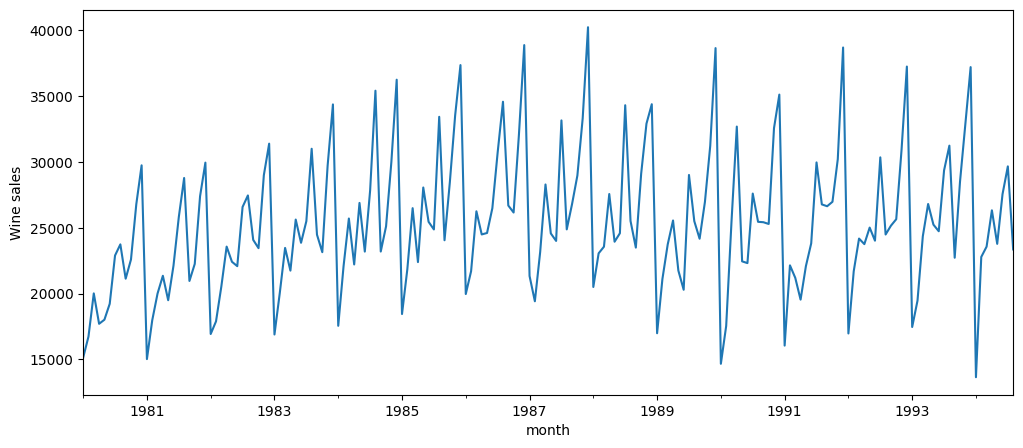

In [20]:
wine = pd.read_csv('data/monthly-australian-wine-sales.csv', 
                   index_col=['month'], parse_dates=['month'])
wine['sales'].plot(figsize=(12,5))
plt.ylabel('Wine sales')
plt.show()

## 1.1. Стабилизация дисперсии

Для стабилизации дисперсии выполним преобразование Бокса-Кокса.

Оптимальный параметр преобразования Бокса-Кокса: 0.236675
Критерий Дики-Фуллера: p=0.029565


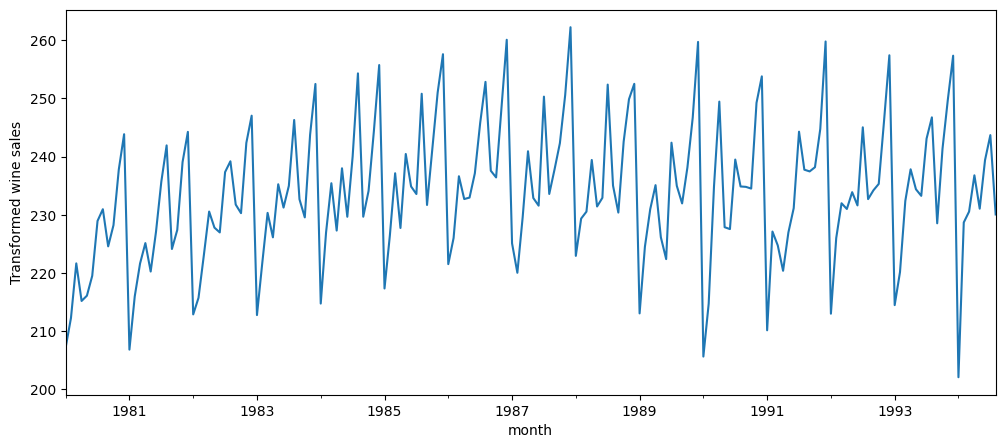

In [21]:
wine['sales'] = wine['sales'] * 1000
wine['sales_box'], lmbda = boxcox(wine['sales'])
wine['sales_box'].plot(figsize=(12,5))
plt.ylabel('Transformed wine sales')
print('Оптимальный параметр преобразования Бокса-Кокса: %f' % lmbda)
print('Критерий Дики-Фуллера: p=%f' % adfuller(wine['sales_box'])[1])

Очевидно наличие сезонности. Сезонность будет учтена во время построения модели SARIMAX, однако для определения порядков авторегресии и скользящего среднего для начала необходимо провести дифференцирование.

## 1.2. Дифференцирование ряда

Критерий Дики-Фуллера: p=0.128317


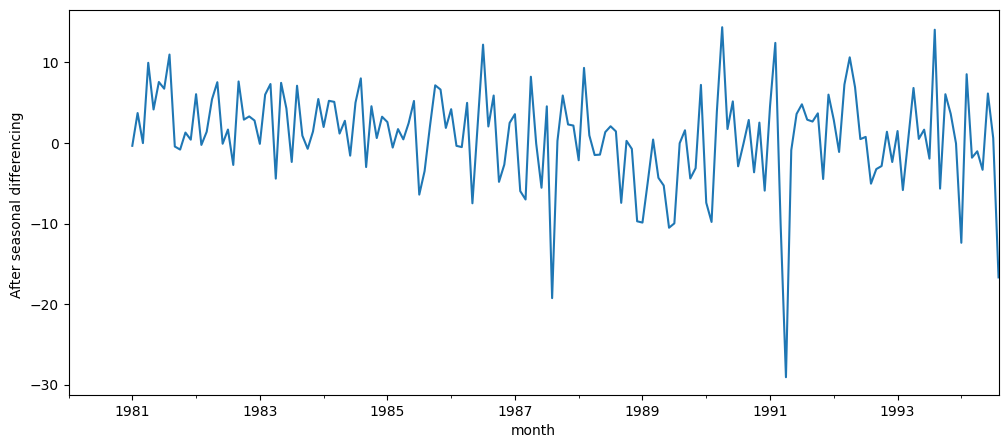

In [22]:
wine['sales_box_sdiff'] = wine['sales_box'].diff(12)
wine['sales_box_sdiff'].plot(figsize=(12,5))
plt.ylabel('After seasonal differencing ')
print('Критерий Дики-Фуллера: p=%f' % adfuller(wine['sales_box_sdiff'].dropna())[1])

Можно заметить, что по критерию Дики-Фуллера ряд не является стационарным. Проведем обычное дифференцирование.

Критерий Дики-Фуллера: p=0.000002


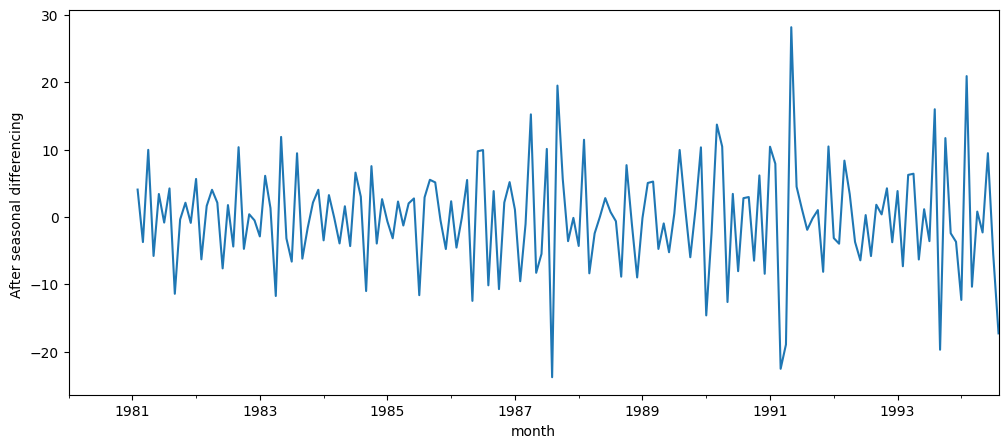

In [23]:
wine['sales_box_diff'] =  wine['sales_box_sdiff'].diff(1)
wine['sales_box_diff'].plot(figsize=(12,5))
plt.ylabel('After seasonal differencing ')
print('Критерий Дики-Фуллера: p=%f' % adfuller(wine['sales_box_diff'].dropna())[1])

Гипотеза нестационарности отвергается. Перейдем к выбору начального приближения гиперпараметров.

## 1.3. Выбор гиперпараметров модели

Для выбора порядка скользящего среднего обратимся к коррелограмме.

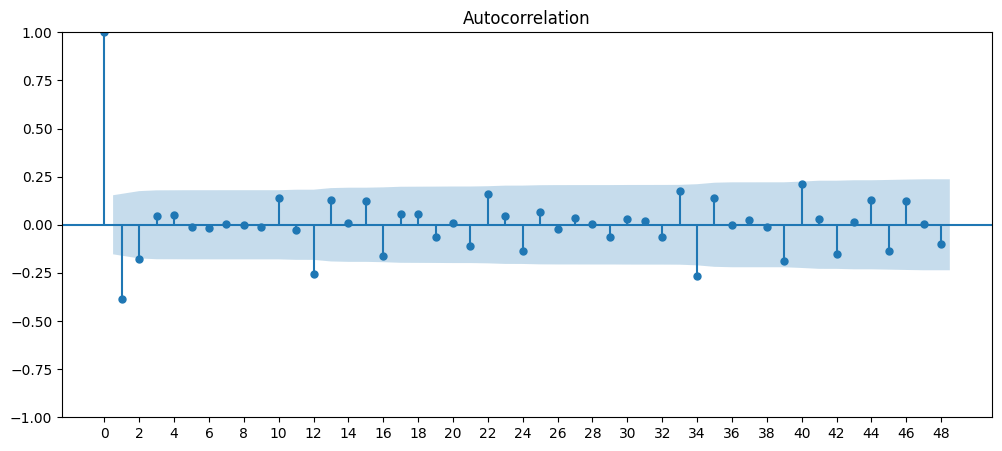

In [24]:
plt.rcParams['figure.figsize'] = (12,5)
plot_acf(wine['sales_box_diff'].dropna(), lags=48)
plt.xticks(np.arange(0, 50, 2))
plt.show()

Посдедний значимый лаг равен 2. А последний значимый сезонный лаг равен 1 (при лаге 12 автокорреляция значима, при 24 &ndash; незначима). Таким образом, $q_0=2, Q_0=1$.

Для выбора порядка авторегрессии обратимся к частичной автокорреляции.

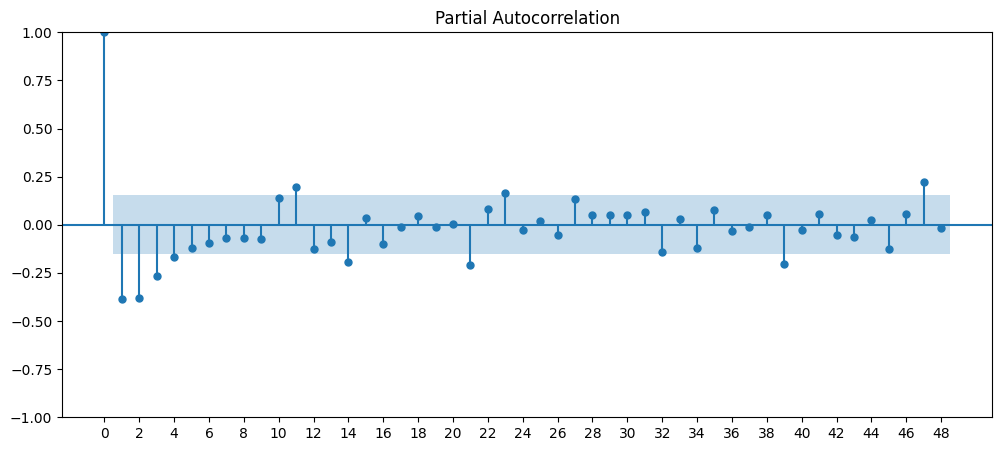

In [25]:
plt.rcParams['figure.figsize'] = (12,5)
plot_pacf(wine['sales_box_diff'].dropna(), lags=48)
plt.xticks(np.arange(0, 50, 2))
plt.show()

Последний значимый лаг оказался равным 4, значит $p_0=4$. Период сезонности составляет 12. При лаге, равном 12, частичная автокорреляция незначима, значит, $P_0=0$.

Таким образом, будем рассматривать следующие наборы гиперпараметров модели SARIMA:

In [26]:
d=1
D=1
p = range(0, 5)
P = range(0, 2)
q = range(0, 3)
Q = range(0, 2)

In [27]:
parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [28]:
len(parameters_list)

60

## 1.4. Выбор оптимальной модели

Получили 60 возможных наборов гиперпараметров. Гиперпараметры модели нельзя выбирать методом максимального правдоподобия, поскольку с увеличением количества параметров значение функции правдоподобия $L$ растет. 

Поэтому для сравнения различных моделей применяется информационный критерий Акаике:
$$AIC=-2L+2k,$$
где $k$ &ndash; число параметров модели. Чем меньше значение данного критерия, тем лучше.

В цикле будем строить модель SARIMAX `model` и, если полученное значение критерия Акаике `aic` меньше, чем на предыдущих шагах, запишем эту модель в переменную `best_model`. Модель SARIMAX принимает первым аргументом (или через `endog`) исходный ряд. Экзогенные факторы можно передать в виде матрицы в аргументе `exog`. В `seasonal_order` передается набор гиперпараметров `(P,D,Q,S)`, где `S` &ndash; период сезонности. Примерное время выполнения: 3 минуты.

In [29]:
wine.index.freq = 'MS'

In [ ]:
results = []
best_aic = float('inf')

for params in parameters_list:
    try:
        model = SARIMAX(wine['sales_box'],
                        order=(params[0], d, params[1]), 
                        seasonal_order=(params[2], D, params[3], 12)).fit()
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = params
    results.append([params, model.aic])

In [ ]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by='aic', ascending=True).head())

## 1.5. Визуализация результата

Визуализируем лучшую полученную модель. Не забудем выполнить обратное преобразование Бокса-Кокса. Обратное дифференцирование будет выполнено функцией SARIMAX.

In [ ]:
wine['model'] = inv_boxcox(best_model.fittedvalues, lmbda)
wine['sales'].plot(figsize=(12,5))
wine.model[13:].plot(color='r')
plt.ylabel('Wine sales')
plt.show()

Прогноз можно получить с помощью методов `predict` (предпочтителен) или `forecast`. `predict` принимает на вход параметры `start` и `end`, в которые необходимо передать даты начала и конца прогноза. `forecast` же принимает на вход целое число &ndash; горизонт прогнозирования (опирается на индексы таблицы и может неверно их интерпретировать).

In [ ]:
start = wine.index[-1] + pd.DateOffset(months=1)
end = start + pd.DateOffset(months=35)

In [ ]:
wine['sales'].plot(figsize=(12,5))
inv_boxcox(best_model.predict(start=start, end=end), lmbda).plot(color='r')
plt.ylabel('Wine sales')
plt.show()

In [ ]:
wine['sales'].plot(figsize=(12,5))
inv_boxcox(best_model.forecast(36), lmbda).plot(color='r')
plt.ylabel('Wine sales')
plt.show()

# 2. Введение в модель Prophet

Для дальнейшей работы понадобится установленная библиотека **FBProphet**: https://facebook.github.io/prophet/.

Для установки откройте терминал анаконды (Anaconda Promt) и запустите следующую команду: `conda install -c conda-forge fbprophet`.

Prophet для визуализации результатов прогнозирования обращается к библиотеке **Plotly**: https://plotly.com/python/, которая позволяет строить интерактивные графики. Можно также установить через conda: `conda install -c plotly plotly=4.6.0` или же через pip. Установка данной библиотеки необязательна.

Подробное описание методов построения прогноза можно найти в работе Forecasting at scale (Facebook Prophet documentation preprint).

Модель прогнозирования в библиотеке от Facebook имеет название `Prophet`. Основной идеей построения прогноза стало разложение временного ряда на основные составляющие:

$$y(t)=g(t)+s(t)+h(t)+f(t)+\epsilon_t,$$

где $g(t)$ &ndash; функция, описывающая тренд временного ряда, $s(t)$ &ndash; компонента, описывающая сезонные колебания, $h(t)$ &ndash; компонента, отвечающая за различные праздники и события, которые могут оказывать влияние на целевую переменную $y(t)$, $f(t)$ &ndash; компонента, учитывающая экзогенные факторы, а $\epsilon_t$ представляет собой непрогнозируемую перечисленными компонентами ошибку.

Построим модель прогнозирования для ряда продаж вина.

## 2.1. Инициализация и обучение модели

In [30]:
from prophet import Prophet

C:\Users\Valeria\.virtualenvs\analysis_and_forecasting-SQK1gn6O\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Функция `Prophet` требует, чтобы исходная таблица с данными содержала два столбца: `ds` с моментами времени и `y` с соответствующими значениями целевой переменной. В предыдущей работе при загрузке набора данных `wine` даты использовались в качестве индексов наблюдений. Поскольку теперь для корректной работы функции данные обязательно должны содержать указанные два столбца, используется индекс по умолчанию. Названия столбцов изменим на `ds` и `y`. Будем использовать ряд после преобразования Бокса-Кокса.

In [31]:
wine.head()

,sales,sales_box,sales_box_sdiff,sales_box_diff
month,,,,
1980-01-01,15136000,207.210491,NaN,NaN
1980-02-01,16733000,212.290060,NaN,NaN
1980-03-01,20016000,221.667748,NaN,NaN
1980-04-01,17708000,215.211724,NaN,NaN
1980-05-01,18019000,216.117795,NaN,NaN


In [32]:
wine_prophet = wine[['sales_box']]
wine_prophet = wine_prophet.reset_index()
wine_prophet.columns = ['ds', 'y']

In [33]:
wine_prophet.head()

,ds,y
0,1980-01-01,207.210491
1,1980-02-01,212.290060
2,1980-03-01,221.667748
3,1980-04-01,215.211724
4,1980-05-01,216.117795


Последовательность построения модели схожа с построением `SARIMAX` из statsmodels с единственным отличием: структура модели задается без указания прогнозируемого ряда. Обучение происходит с помощью той же функциии `fit`, где уже указывается набор данных в виде `pd.DataFrame` с указанными выше столбцами.

In [34]:
model = Prophet(weekly_seasonality=False, daily_seasonality=False)
model.fit(wine_prophet)

11:17:40 - cmdstanpy - INFO - Chain [1] start processing
11:17:40 - cmdstanpy - INFO - Chain [1] done processing


Для построения прогноза потребуется также передать `pd.DataFrame`, содержащий столбец `ds`. Для создания такой таблицы в Prophet предусмотрена функция `make_future_dataframe`, в которой можно указать горизонт прогнозирования `periods` и частоту наблюдений `freq`. Без указанной частоты будет построен подневный прогноз. Будем также строить прогноз на 3 года вперед. `make_future_dataframe` вернет даты с первого наблюдения до последней даты прогноза.

In [35]:
future = model.make_future_dataframe(periods=36, freq='MS')

Аппроксимацию построенной моделью и прогноз теперь можно получить с помощью функции `predict`, которая вернет `pd.DataFrame` с результатами.

In [36]:
forecast = model.predict(future)

Приведем оценки модели и прогнозный интервал для последних 12 спрогнозированных значений:

In [38]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

,ds,yhat,yhat_lower,yhat_upper
200,1996-09-01,232.279213,226.862209,237.814524
201,1996-10-01,239.142720,233.500842,244.961953
202,1996-11-01,249.014052,243.267139,254.804916
203,1996-12-01,256.268255,250.838747,261.979663
204,1997-01-01,215.057610,209.365675,220.742123
205,1997-02-01,224.247902,218.727758,229.827228
206,1997-03-01,233.398498,227.780897,238.920223
207,1997-04-01,234.287007,228.043732,240.114949
208,1997-05-01,233.130281,227.571649,238.690746
209,1997-06-01,232.806002,226.996264,238.692246


Для удобства `Prophet` позволяет сразу отобразить результаты на графике.

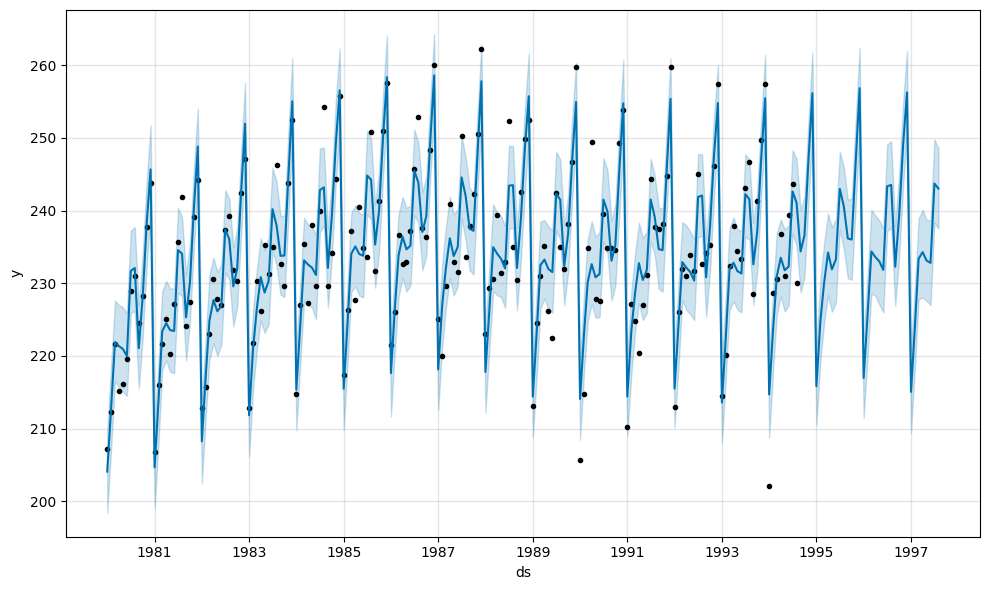

In [39]:
model.plot(forecast)
plt.show()

## 2.2. Моделирование тренда

Prophet позволяет моделировать затухающий тренд, задав при этом порог насыщения. Такая возможность может пригодиться, например, при прогнозировании числа пассажиров на рейс, где ограничена вместимость воздушного судна, которое назначено на данный рейс. В данном случае порог можно установить равным вместимости судна. Для моделирования затухающего тренда при инициализации модели необходимо указать `growth = 'logistic'`. Установить порог можно, добавив к данным столбец `cap` для ограничения сверху или `floor` для ограничения снизу.

In [27]:
# model_logistic = Prophet(growth='logistic')

Кроме того, в Prophet реализована возможность задавать точки изменения тренда (changepoints). По умолчанию Prophet равномерно распределяет 25 таких точек по ряду.

In [28]:
# model_changepoints = Prophet(changepoints=['2014-01-01'])

## 2.3. Моделирование сезонности

Для моделирования сезонности в пакете Prophet используется ничто иное как Фурье-преобразования, которые проводятся по формулам:

$$s(t)=\sum_{n=1}^{N}\left(a_n cos \left( \frac{2\pi n t}{P} \right)+b_n sin \left(\frac{2\pi n t}{P}\right) \right).$$

Здесь $N$ &ndash; порядок Фурье-преобразования. Для годовой сезонности эмпирическим путем исследователи Facebook определили оптимальный порядок $N=10$, для недельной сезонности &ndash; $N=3$.

Сезонные составляющие можно передать в модель при инициализации, а можно добавлять сезонные компоненты к уже определенной модели с указанием периода и порядка преобразования.

In [29]:
model = Prophet(weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=False)
model.add_seasonality(name='yearly', period=365.25, fourier_order=10)

Таким образом `add_seasonality` позволяет добавить специфические периоды сезонности, характерные для конкретного ряда, например, с периодом сезонности равном 5, если данные собираются исключительно во время рабочей недели.

При наличии мультипликативной сезонности при инициализации модели указывается опция `seasonality_mode='multiplicative'`.

## 2.4. Добавление праздников

Во временной ряд о продажах вина трудно добавить информацию о праздниках, но по графику заметно, что продажи растут в конце года и падают в начале. Таким образом, можно добавить Новый год в качестве фактора. Список праздников должен быть передан также в виде `pd.DataFrame` с указанием названий праздников в столбце `holiday`, дат праздников `ds`, а также количества дней до `lower_window` и после праздников `upper_window`, в которые также могут наблюдаться изменения спроса.

In [40]:
new_year = pd.DataFrame({'holiday': 'NewYear', 
                         'ds': pd.to_datetime([str(x)+'-01-01' for x in range(1980, 1997)]),
                         'lower_window': -7, 
                         'upper_window': 7
                        })

Список праздников затем передается в модель:

In [41]:
model_holiday = Prophet(weekly_seasonality=False, daily_seasonality=False, holidays=new_year)

Официальные праздники разных стран доступны по их двухбуквенному коду в самом пакете.

In [42]:
model_holidays = Prophet(weekly_seasonality=False, daily_seasonality=False)
model_holidays.add_country_holidays(country_name='AU')
model_holidays.fit(wine_prophet)

11:18:19 - cmdstanpy - INFO - Chain [1] start processing
11:18:19 - cmdstanpy - INFO - Chain [1] done processing


In [43]:
model_holidays.train_holiday_names

0                 Australia Day
1                     Anzac Day
2                    Boxing Day
3                New Year's Day
4     New Year's Day (Observed)
5                   Good Friday
6                 Easter Monday
7                 Christmas Day
8      Australia Day (Observed)
9         Boxing Day (Observed)
10     Christmas Day (Observed)
dtype: object

## 2.5. Добавление экзогенных факторов

Дополнительные факторы, которые могут улучшить качество прогноза можно добавить с помощью функции `add_regressor`. Исключительно для примера обратим внимание модели на декабрь каждого года.

In [44]:
def december(ds):
    return 1 if ds.month == 12 else 0

Чтобы добавить дополнительные переменные в модель, их необходимо добавить к матрице с данными `wine_prophet` и затем указать в модели названия колонок с дополнительными переменными.

In [45]:
wine_prophet['december'] = wine_prophet['ds'].apply(december)
wine_prophet.head()

,ds,y,december
0,1980-01-01,207.210491,0
1,1980-02-01,212.290060,0
2,1980-03-01,221.667748,0
3,1980-04-01,215.211724,0
4,1980-05-01,216.117795,0


In [46]:
model_december = Prophet(weekly_seasonality=False, daily_seasonality=False)
model_december.add_regressor('december')
model_december.fit(wine_prophet)

11:18:21 - cmdstanpy - INFO - Chain [1] start processing
11:18:22 - cmdstanpy - INFO - Chain [1] done processing


Для построения прогноза также необходимо добавить экзогенные факторы:

In [27]:
future_december = model_december.make_future_dataframe(periods=36, freq='MS')
future_december['december'] = future_december['ds'].apply(december)
forecast_december = model_december.predict(future_december)

<div class="alert alert-info">

<h4> Задание (выполнять в отдельном файле)</h4>
<p></p>
Для своего ряда построить прогноз на несколько периодов сезонности с применением возможностей библиотеки Prophet. Меняя параметры модели, добиться наилучшего качества аппроксимации. Сравнить на графике прогноз модели SARIMAX с прогнозом модели Prophet. Сравнить качество аппроксимации моделей с помощью MSE.
</div>

<p></p>
</div>